In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

Epoch Number:  17


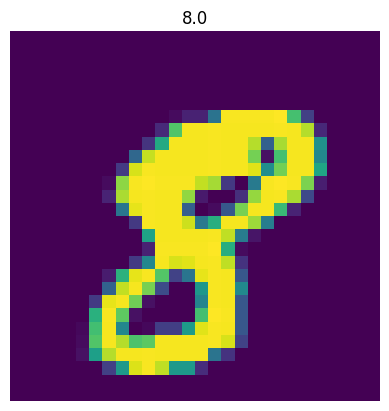

33600
8400


In [5]:
train = pd.read_csv("./train.csv", dtype=np.float32)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                              targets_numpy,
                                                                              test_size=0.2,
                                                                              random_state=42)

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
print("Epoch Number: ", num_epochs)

train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

print(len(train_loader.dataset))
print(len(test_loader.dataset))

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.layer_dim = layer_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out[:, -1, :])
        
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = error(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        count += 1
        
        if count % 500 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                
                images = images.view(-1, seq_dim, input_dim)
                
                outputs = model(images)
                
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / total
            
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data.item(), accuracy))

Iteration: 500. Loss: 2.2662789821624756. Accuracy: 19.58333396911621
Iteration: 1000. Loss: 1.1783500909805298. Accuracy: 66.05952453613281
Iteration: 1500. Loss: 0.3382153809070587. Accuracy: 86.70237731933594
Iteration: 2000. Loss: 0.2652239501476288. Accuracy: 92.21428680419922
Iteration: 2500. Loss: 0.19932779669761658. Accuracy: 93.8452377319336
Iteration: 3000. Loss: 0.08198905736207962. Accuracy: 95.4047622680664
Iteration: 3500. Loss: 0.21157173812389374. Accuracy: 95.55952453613281
Iteration: 4000. Loss: 0.0197798702865839. Accuracy: 96.4047622680664
Iteration: 4500. Loss: 0.10819151997566223. Accuracy: 97.01190185546875
Iteration: 5000. Loss: 0.027355315163731575. Accuracy: 97.0952377319336
Iteration: 5500. Loss: 0.11739616096019745. Accuracy: 96.92857360839844


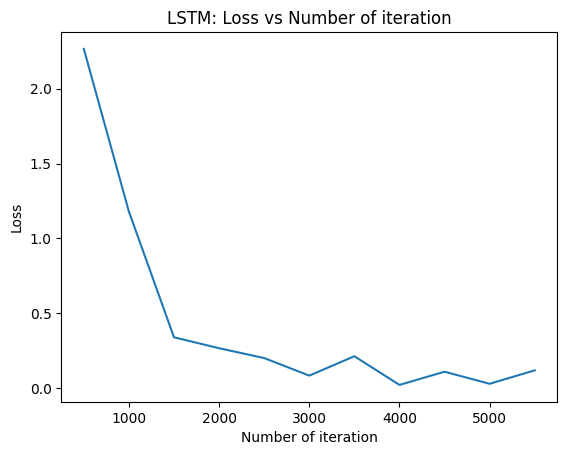

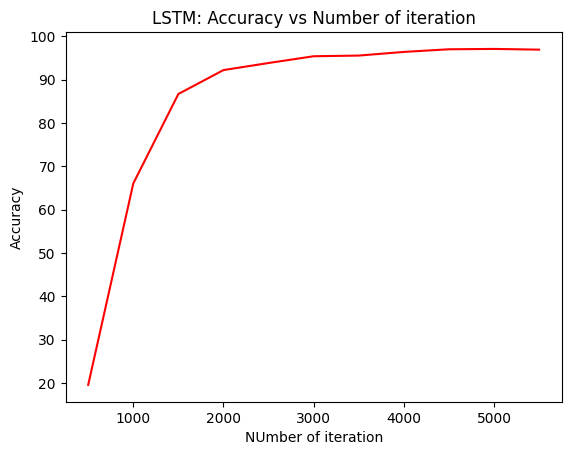

In [12]:
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list, accuracy_list, color = "red")
plt.xlabel("NUmber of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()